In [ ]:
# =======================
# 📦 1. Install dependencies
# =======================
!apt update
!apt install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf xvfb python-opengl ffmpeg
!pip install gymnasium[mujoco] stable-baselines3[extra] pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,927 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,209 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-secur

In [ ]:
# =======================
# 📚 2. Imports
# =======================
import os
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from pyvirtualdisplay import Display

In [ ]:
# Start virtual display for Mujoco rendering (optional for Colab)
Display(visible=0, size=(1400, 900)).start()

# =======================
# ⚙ 3. Device
# =======================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# =======================
# 📂 4. Paths
# =======================
log_dir = "//content/drive/MyDrive/Colab Notebooks/Reinforcement_Learning/Stable_Baseline/ppo_h_standup_log/"
model_path = os.path.join(log_dir, "ppo_humanoid_standup.zip")
os.makedirs(log_dir, exist_ok=True)

# =======================
# 🎮 5. Create Parallel VecNormalize Envs
# =======================
n_envs = 8  # Parallel environments
env = VecNormalize(
    make_vec_env("HumanoidStandup-v5", n_envs=n_envs, vec_env_cls=SubprocVecEnv),
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.
)

eval_env = VecNormalize(
    make_vec_env("HumanoidStandup-v5", n_envs=1),
    training=False,
    norm_obs=True,
    norm_reward=False
)


Using device: cpu


In [ ]:
# =======================
# 💾 6. Checkpoint Callback
# =======================
class CheckpointCallback(BaseCallback):
    def __init__(self, save_freq, save_path, verbose=1):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:
            save_file = os.path.join(self.save_path, "ppo_humanoid_standup_latest.zip")
            self.model.save(save_file)
            env.save(os.path.join(self.save_path, "vecnormalize_latest.pkl"))  # Save normalization stats
            if self.verbose > 0:
                print(f"Checkpoint saved at step {self.num_timesteps} -> {save_file}")
        return True

checkpoint_callback = CheckpointCallback(save_freq=50_000, save_path=log_dir)

In [ ]:
# =======================
# 📊 7. Evaluation Callback
# =======================
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=50_000,
    deterministic=True,
    render=False,
    n_eval_episodes=5
)

# =======================
# 🧠 8. PPO Policy Config
# =======================
policy_kwargs = dict(
    net_arch=[512, 256, 128],
    activation_fn=torch.nn.ReLU
)

# =======================
# 🚀 9. Load or Create PPO Model
# =======================
if os.path.exists(model_path):
    print("Loading existing model...")
    model = PPO.load(model_path, env=env, device=device)
    env = model.get_env()
else:
    print("Creating new model...")
    model = PPO(
        "MlpPolicy",
        env,
        device=device,
        verbose=1,
        tensorboard_log=log_dir,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=4096,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        policy_kwargs=policy_kwargs,
    )

Loading existing model...


In [ ]:

# =======================
# 🏋 10. Training
# =======================
print("Starting training...")
model.learn(
    total_timesteps=10_000_000,  # Recommend 5M+ for good results
    callback=[eval_callback, checkpoint_callback],
    tb_log_name="ppo_humanoid_standup",
    progress_bar=True
)

# =======================
# 💾 11. Save Final Model & VecNormalize
# =======================
model.save(model_path)
env.save(os.path.join(log_dir, "vecnormalize_final.pkl"))
print("Training completed.")


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10,010,616/10,000,000  [ 3:07:23 < 0:00:00 , 664 it/s ]

Training completed.


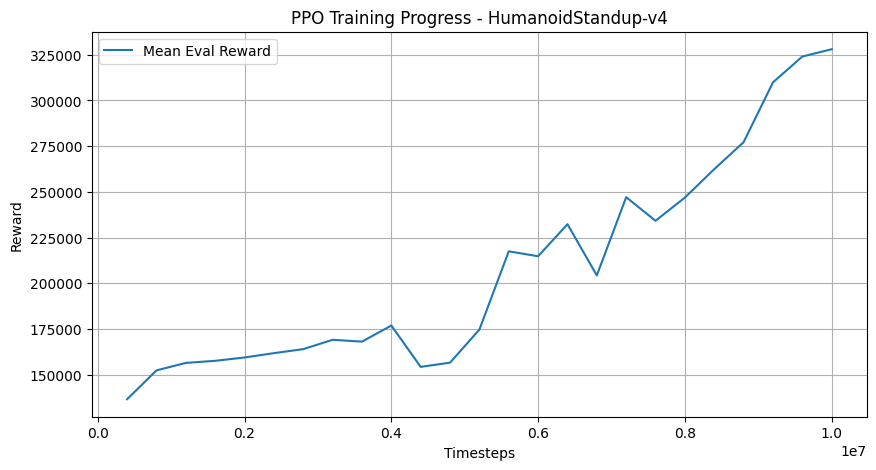

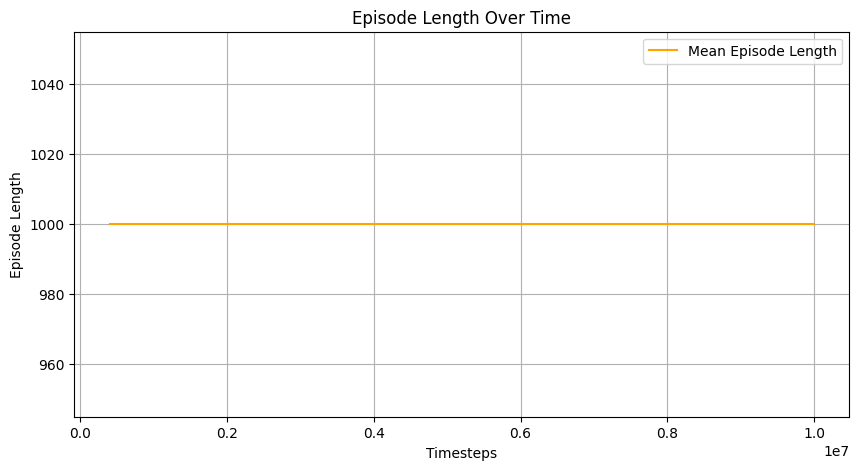

✅ Plots saved to /content/drive/MyDrive/Colab Notebooks/Reinforcement_Learning/Stable_Baseline/ppo_h_standup_log/


In [ ]:
# =======================
# 📊 12. Plot Training Progress
# =======================
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Monitor file from EvalCallback
eval_log_file = os.path.join(log_dir, "evaluations.npz")

if os.path.exists(eval_log_file):
    data = np.load(eval_log_file)
    timesteps = data["timesteps"]
    results = data["results"].mean(axis=1)  # average reward over episodes
    ep_lengths = data["ep_lengths"].mean(axis=1)

    # Ensure directory exists
    os.makedirs(log_dir, exist_ok=True)

    # Plot Mean Eval Reward
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, results, label="Mean Eval Reward")
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.title("PPO Training Progress - HumanoidStandup-v4")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(log_dir, "mean_eval_reward.png"), dpi=300)
    plt.show()

    # Plot Mean Episode Length
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, ep_lengths, label="Mean Episode Length", color="orange")
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Length")
    plt.title("Episode Length Over Time")
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(log_dir, "episode_length.png"), dpi=300)
    plt.show()

    print(f"✅ Plots saved to {log_dir}")
else:
    print("⚠ No evaluation log found. Make sure EvalCallback ran during training.")


In [ ]:
import os
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.vec_env.vec_normalize import VecNormalize
import gymnasium as gym

# ==========================
# 1. Paths
# ==========================
log_dir = "/content/drive/MyDrive/Colab Notebooks/Reinforcement_Learning/Stable_Baseline/ppo_h_standup_log/"
model_path = os.path.join(log_dir, "ppo_humanoid_standup.zip")
vecnorm_path = os.path.join(log_dir, "vecnormalize_final.pkl")  # Final saved stats
video_folder = "/content/h_stand_videos/"
os.makedirs(video_folder, exist_ok=True)

# ==========================
# 2. Force CPU execution
# ==========================
device = "cpu"

# ==========================
# 3. Create test environment in rgb_array mode
# ==========================
def make_env():
    return gym.make("HumanoidStandup-v5", render_mode="rgb_array")

env = DummyVecEnv([make_env])

# ==========================
# 4. Load VecNormalize stats (important for PPO performance)
# ==========================
if os.path.exists(vecnorm_path):
    print("Loading VecNormalize stats...")
    env = VecNormalize.load(vecnorm_path, env)
    env.training = False
    env.norm_reward = False
else:
    print("No VecNormalize stats found — running without normalization.")

# ==========================
# 5. Wrap env with video recorder
# ==========================
env = VecVideoRecorder(
    env,
    video_folder=video_folder,
    record_video_trigger=lambda step: step == 0,
    video_length=1000,
    name_prefix="ppo_h_stand_eval"
)

# ==========================
# 6. Load PPO model
# ==========================
print("Loading trained model...")
model = PPO.load(model_path, env=env, device=device)

# ==========================
# 7. Run the agent & track rewards
# ==========================
obs = env.reset()
total_reward = 0.0

for _ in range(1000):  # 1000 timesteps
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, _ = env.step(action)
    total_reward += rewards[0]  # rewards is a vector since DummyVecEnv is used
    if dones.any():
        break

env.close()

print(f"Total Reward: {total_reward}")
print(f"Video saved in {video_folder}")


Loading VecNormalize stats...
Loading trained model...
Saving video to /content/h_stand_videos/ppo_h_stand_eval-step-0-to-step-1000.mp4
Moviepy - Building video /content/h_stand_videos/ppo_h_stand_eval-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/h_stand_videos/ppo_h_stand_eval-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/h_stand_videos/ppo_h_stand_eval-step-0-to-step-1000.mp4
Total Reward: 316006.34375
Video saved in /content/h_stand_videos/
